# WhatsApp Group Chat Analysis

In [1]:
# import generic libraries
import numpy as np
import pandas as pd
import os, re
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [34]:
# import text processing libraries
from textblob import TextBlob
import contractions, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
import profanity_check

### Import data from log, split and format as dataframes:

In [ ]:
# read text from file
f = open('_chat.txt', "r", encoding="utf8")
s = f.read()
f.close()

# remove formatting characters
s = s.replace('\u200e', '')
s = s.replace('\u202a', '')
s = s.replace('\xa0', '')
s = s.replace('\u202c', '')

# split by date
dateformat = '(\[\d+/\d+/\d+, \d+:\d+:\d+\])' # edit if required 
lines = re.compile(dateformat).split(s)

# remove empty string at start
lines.pop(0)

# select and format datetimes
datetimes = [pd.to_datetime(d[1:-1], format='%d/%m/%Y, %H:%M:%S') for d in lines[::2]]

# select corresponding messages
lines = lines[1::2]

# remove new line thing (\n) at the end of lines and the space at the beginning
lines = [line[1:-1] for line in lines]

# are they messages or info about people leaving/joining? There are colons at the end of names if messages
message = []

for line in lines:
    if line.split()[0][-1] == ':' or line.split()[1][-1] == ':':
        message.append('msg')
    else:
        message.append('info')
        
# create dataframe
df = pd.DataFrame({'datetime':datetimes, 'text':lines, 'message':message})

# split into seperate dataframes
messages = df[df.message == 'msg']
info = df[df.message == 'info']

# remove redundant column used for splitting
messages = messages.drop(['message'], axis=1)
info = info.drop(['message'], axis=1)

# extract names of senders
messages['name'] = [msg.split(':')[0] for msg in messages.text]

# remove names from messages
def strip_name(msg): 
    return msg[msg.find(':')+2:]

messages['text'] = messages.text.apply(strip_name)

# view senders for editing
messages.name.value_counts()

### Make replacements where individual members are associated with multiple contacts:

In [4]:
# replace names
def replacer(name):
    if name == 'REMOVED':
        return 'Will'
    elif name == 'REMOVED':
        return 'Will'
    elif name == 'REMOVED':
        return 'Sam'
    elif name == 'REMOVED':
        return 'Sam'
    elif name == 'REMOVED':
        return 'Sam'
    elif name == 'REMOVED':
        return 'Ben'
    elif name == 'REMOVED':
        return 'Dom'
    elif name == 'REMOVED':
        return 'Tom'
    elif name == 'REMOVED':
        return 'Dan'
    elif name == 'REMOVED':
        return 'Dan'
    else:
        return name
    
messages['name'] = messages.name.apply(replacer)

# remove dead lines
messages = messages[messages.name.isin(['Will', 'Ben', 'Dan', 'Sam', 'Dom', 'Tom'])]

# view sample
messages.head(3)

,datetime,text,name
2,2012-07-14 05:03:18,Nah then lads…,Dan
6,2012-07-14 05:04:24,We all psyched up for a mad one in Donny?,Dan
7,2012-07-14 05:04:38,What is this? 3 way what's app?,Will


### Plot group activity over time:

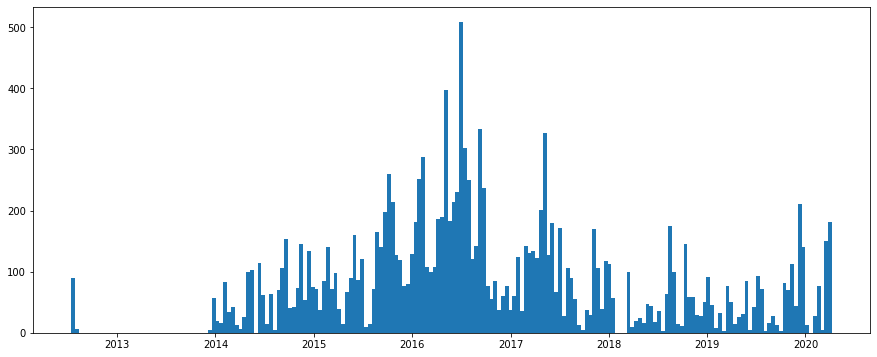

In [5]:
# histogram of datetimes
plt.figure(figsize=(15,6))
plt.hist(messages.datetime, bins=200);

### Calculate how long people tend to have to wait for a reply:

In [6]:
# calculate time until someone replies
waits = []
for i in range(messages.shape[0]-1):
    waits.append(messages.datetime.iloc[i+1] - messages.datetime.iloc[i])
    
# add an arbitrary zero value onto the end
waits.append(waits[0]-waits[0])

# convert to minutes
minutes = [np.round(((wait.seconds / 60) + 24*60*wait.days), 2) for wait in waits]

# add to dataframe
messages['wait'] = waits
messages['minutes'] = minutes

In [7]:
# create function for plotting bar charts by group member
def plot_x(x, title=None, ylab=None):
    x.sort_index()
    plt.figure(figsize=(10,6))
    sns.barplot(x.index, x.values)
    plt.ylabel(ylab)
    plt.xlabel(None)
    plt.title(title);

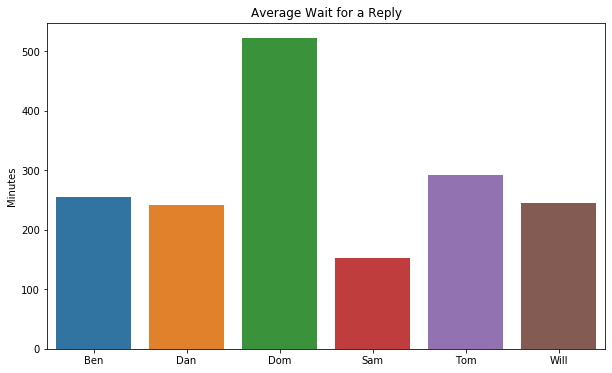

In [8]:
# plot how long it takes to get a reply
x = messages.groupby('name')['minutes'].mean()
plot_x(x, title='Average Wait for a Reply', ylab='Minutes')

In [9]:
# find longest ever silence
ls = messages[messages.wait == max(messages.wait)]

f"The longest recorded silence lasted {ls.wait.iloc[0]}, \
after {ls.name.iloc[0]} said '{ls.text.iloc[0]}' \
on {ls.datetime.iloc[0].date().strftime('%d %B %Y')}"

"The longest recorded silence lasted 497 days 10:56:04, after Dom said 'Sting' on 05 August 2012"

### Look at amounts of various media items shared:

Total images shared: 1063


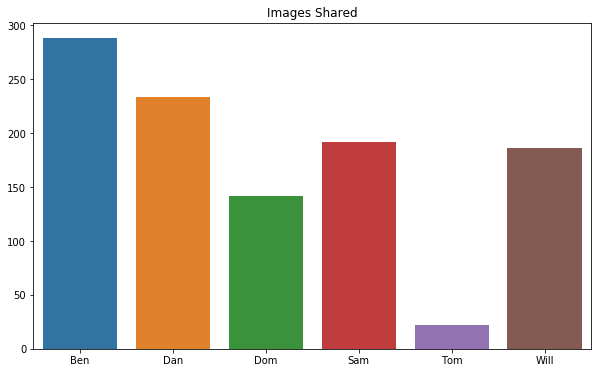

In [10]:
# get lower case messages for more consistent searching
messages['lower'] = messages['text'].str.lower()

# count total images shared 
print(f"Total images shared: {messages[messages.lower.str.contains('image omitted')].shape[0]}")

# plot image shared by member
images = messages[messages.lower.str.contains('image omitted')]
x = images.groupby('name')['minutes'].count()
plot_x(x, title='Images Shared')

Total GIFs shared: 28


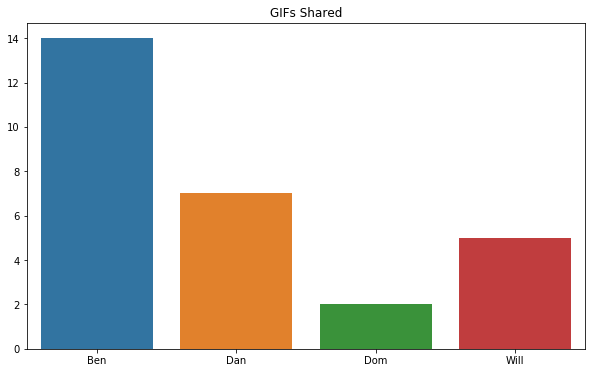

In [11]:
# count total GIFs shared 
print(f"Total GIFs shared: {messages[messages.lower.str.contains('gif omitted')].shape[0]}")

# plot GIFs shared by member
gifs = messages[messages.lower.str.contains('gif omitted')]
x = gifs.groupby('name')['minutes'].count()
plot_x(x, title='GIFs Shared')

Total videos shared: 95


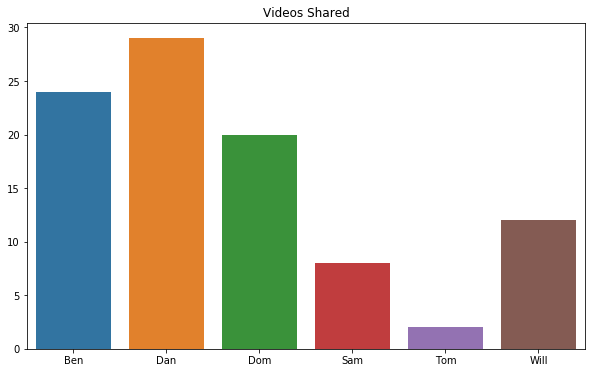

In [12]:
# count total videos shared 
print(f"Total videos shared: {messages[messages.lower.str.contains('video omitted')].shape[0]}")

# plot video shared by member
videos = messages[messages.lower.str.contains('video omitted')]
x = videos.groupby('name')['minutes'].count()
plot_x(x, title='Videos Shared')

Total audio files shared: 157


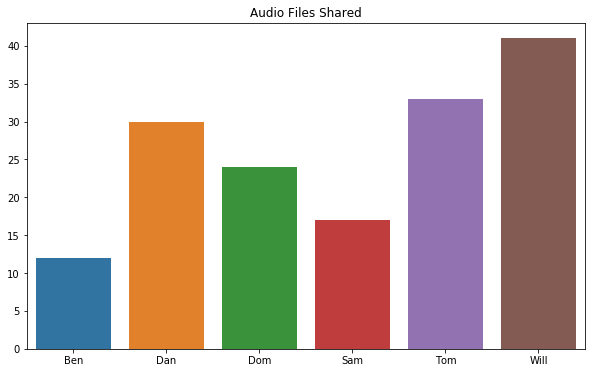

In [13]:
# count total audio shared 
print(f"Total audio files shared: {messages[messages.lower.str.contains('audio omitted')].shape[0]}")

# plot audio shared by member
audio = messages[messages.lower.str.contains('audio omitted')]
x = audio.groupby('name')['minutes'].count()
plot_x(x, title='Audio Files Shared')

In [14]:
# remove messages that just refer to a media file as they are no longer needed
messages = messages[~messages['lower'].str.contains('omitted')]

### Clean up the text:

In [15]:
# expand contractions
messages['tokens'] = messages['lower'].apply(lambda x: [contractions.fix(word) for word in x.split()])

# convert back to single string
messages['expanded_text'] = [' '.join(map(str, li)) for li in messages['tokens']]

# re-establish tokens using expanded contractions and NLTK's tokeniser
messages['tokens'] = messages['expanded_text'].apply(word_tokenize)

# convert to lower
messages['tokens'] = messages['tokens'].apply(lambda x: [word.lower() for word in x])

# remove punctuation
punc = string.punctuation

messages['tokens'] = messages['tokens'].apply(lambda x: [word for word in x if word not in punc])

# remove stopwords
stop_words = set(stopwords.words('english'))
messages['tokens'] = messages['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# first get NLTK POS tags
messages['nltk_pos'] = messages['tokens'].apply(nltk.tag.pos_tag)

# create function to translate to wordnet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# translate to wordnet POS tags
messages['wordnet_pos'] = messages['nltk_pos'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

# apply the lemmatization usines WordNet POS tags
wnl = WordNetLemmatizer()
messages['lemmas'] = messages['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word,pos) for (word, pos) in x])

# save cleaned data
messages.to_pickle('clean_text.pkl')

# view
messages.head(3)

,datetime,text,name,wait,minutes,lower,tokens,expanded_text,nltk_pos,wordnet_pos,lemmas
2,2012-07-14 05:03:18,Nah then lads…,Dan,00:01:06,1.10,nah then lads…,"[nah, lads…]",nah then lads…,"[(nah, NNS), (lads…, VBP)]","[(nah, n), (lads…, v)]","[nah, lads…]"
6,2012-07-14 05:04:24,We all psyched up for a mad one in Donny?,Dan,00:00:14,0.23,we all psyched up for a mad one in donny?,"[psyched, mad, one, donny]",we all psyched up for a mad one in donny?,"[(psyched, VBN), (mad, JJ), (one, CD), (donny,...","[(psyched, v), (mad, a), (one, n), (donny, n)]","[psyched, mad, one, donny]"
7,2012-07-14 05:04:38,What is this? 3 way what's app?,Will,00:00:17,0.28,what is this? 3 way what's app?,"[3, way, app]",what is this? 3 way what is app?,"[(3, CD), (way, NN), (app, NN)]","[(3, n), (way, n), (app, n)]","[3, way, app]"


### Plot overall message frequencies by member:

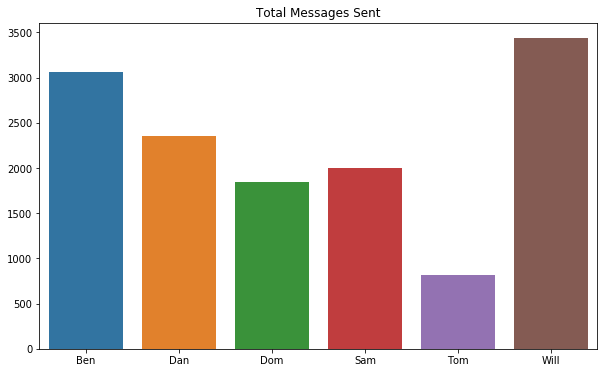

In [16]:
# plot total message frequencies
x = messages.groupby('name')['lower'].count()
plot_x(x, title='Total Messages Sent')

### Calculate sentiment scores using TextBlob:

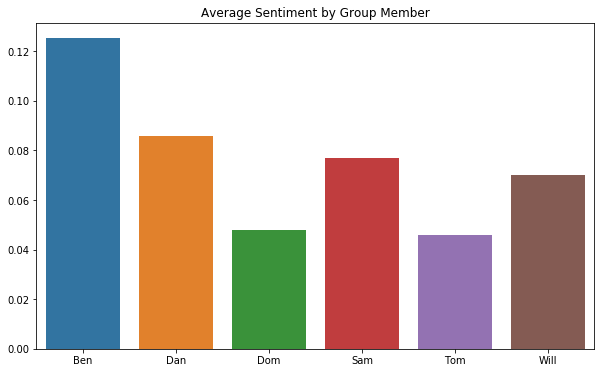

In [17]:
# create a string of the lemmas
messages['lemma_str'] = [' '.join(map(str, li))for li in messages['lemmas']]

# calculate sentiment
messages['sentiment'] = messages['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

# plot results
x = messages.groupby('name')['sentiment'].mean()
plot_x(x, title='Average Sentiment by Group Member')

### Calculate average words per message:

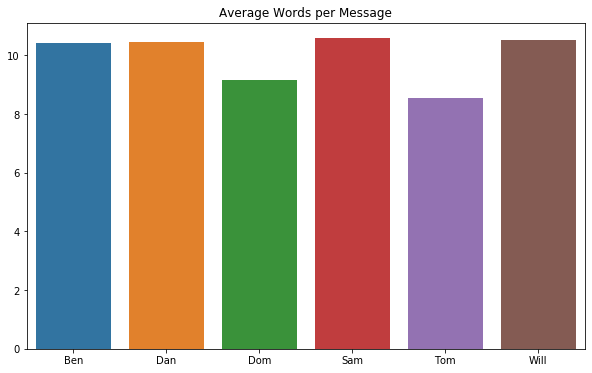

In [18]:
# count words in each message 
messages['words'] = messages['text'].apply(lambda x: len(x.split()))

# plot mean words per message
x = messages.groupby('name')['words'].mean()
plot_x(x, title='Average Words per Message')

### Calculate average word length per member:

In [19]:
# create function to calculate average word length per member
def avg_word_length(member):

    person_lists = messages['lemmas'][messages.name == member]
    big_string = ''

    for li in person_lists:
        for w in li:
            big_string = big_string + w + ' '
            
    w = len(big_string.split())
    c = len(big_string)
    
    return (c + 1 - w) / w

In [20]:
members = messages.name.value_counts().index.values.tolist()

# iterate through members on average word length
for member in members:
    print(f'Average word length for {member} = {np.round(avg_word_length(member), 2)} letters per word')

Average word length for Will = 5.21 letters per word
Average word length for Ben = 5.39 letters per word
Average word length for Dan = 5.01 letters per word
Average word length for Sam = 5.22 letters per word
Average word length for Dom = 5.19 letters per word
Average word length for Tom = 4.98 letters per word


### Create wordclouds of most common words

In [21]:
# create word cloud making function for a single member
def make_wordcloud(member):

    person_lists = messages['lemmas'][messages.name == member]
    big_string = ''

    for li in person_lists:
        for w in li:
            big_string = big_string + w + ' '

    wc = WordCloud(width=1600, height=900, background_color='white').generate(big_string)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off');

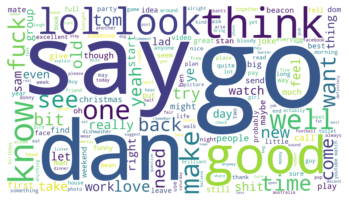

In [22]:
# view wordcloud for an arbitrary member
make_wordcloud('Will')

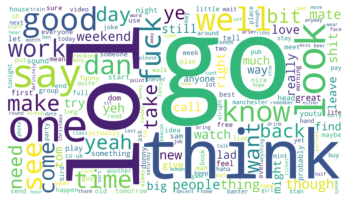

In [23]:
# create wordcloud for entire chat history
word_lists = messages['lemmas']
big_string = ''

for li in word_lists:
    for w in li:
        big_string = big_string + w + ' '

wc = WordCloud(width=1600, height=900, background_color='white').generate(big_string)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

### Count prevalence of a particular word:

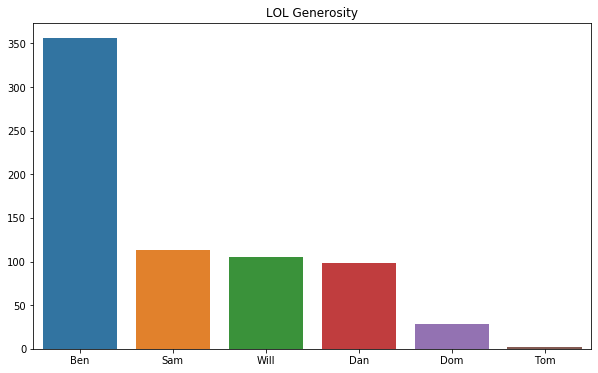

In [24]:
# count lols dished out
x = messages[messages['lemma_str'].str.contains('lol')]['name'].value_counts()
plot_x(x, title='LOL Generosity')

### Chart most common words for a specific member:

In [25]:
# create bar chart of most common words
def top_word_chart(person):
    person_lists = messages['lemmas'][messages.name == person]
    all_words = []

    for li in person_lists:
        all_words += li

    top15 = FreqDist(all_words).most_common(15)
    plt.figure(figsize=(15,6))
    x, y = zip(*top15)
    plt.bar(x, y);

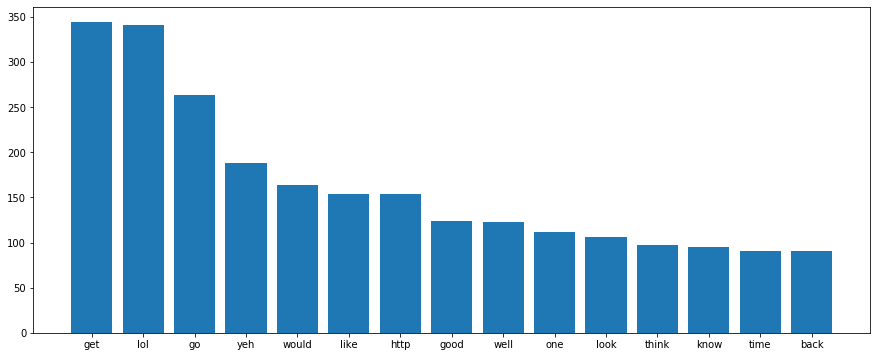

In [26]:
top_word_chart('Ben')

### See who's left or been removed from the group and when:

In [33]:
# search info posts for people leaving the group
info[info.text.str.contains('left|removed')]

,datetime,text
106,2012-08-14 06:05:42,You were removed
246,2014-02-01 07:07:41,Welsh left
516,2014-05-10 20:25:40,Dom left
517,2014-05-10 20:25:41,Welsh left
1915,2015-02-07 00:35:12,Dom left
4074,2015-11-16 04:03:37,Tom Knight left
14678,2020-03-22 22:57:18,Dom left
14697,2020-03-23 08:06:59,Dom left


### Count overall use of emojis:

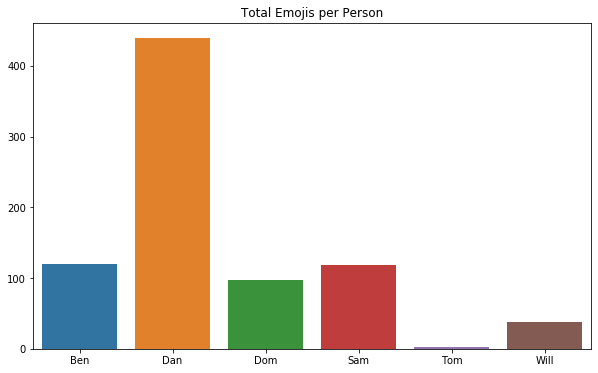

In [28]:
# count emojis
messages['emojis'] = messages['text'].apply(lambda x: len(re.findall('[\U0001f000-\U0001f999]', x)))

# emojis per person
x = messages.groupby('name')['emojis'].sum()
plot_x(x, title='Total Emojis per Person')

### Calculate proportion of each user's messages that use offensive language:

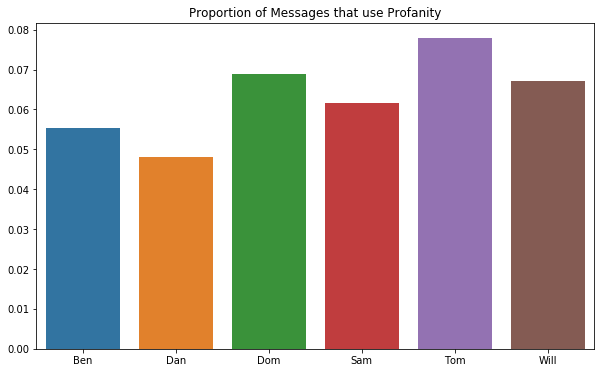

In [35]:
# predict whether each message uses profane language
messages['profanity'] = profanity_check.predict(messages.lower)

# plot the proportion of profane messages per person
x = messages.groupby('name')['profanity'].mean()
plot_x(x, title='Proportion of Messages that use Profanity')